In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math
import os, cv2
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.metrics import AUC
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import model_from_json, load_model

In [2]:
def ck():    
    dir_list = os.listdir('CK+48')
    img_list = []
    dim = 48
    for folder in dir_list:
        img_path_list = os.listdir('CK+48' + '/' + folder)
        for img_path in img_path_list:
            img = cv2.imread('CK+48' + '/' + folder + '/' + img_path)
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            gray_img = cv2.resize(gray_img, (dim, dim))
            img_resize = gray_img.flatten()
            img_resize = " ".join(str(x) for x in img_resize)
    #         dim = int(math.sqrt(len(img_resize.split(' '))))
            img_list.append(tuple([img_resize, folder]))
    df = pd.DataFrame(img_list, columns=['pixels', 'emotion'])
    
    def img_aug(px):
        image = np.array(px.split(' ')).reshape(dim, dim).astype('float32')
        image = tf.image.random_flip_left_right(image.reshape(dim, dim, 1))
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, 0.2, 0.5)
        image = tf.clip_by_value(image, 0, 255)
        augmented_img = image.numpy().reshape(dim, dim)
        img_concat = ' '.join(augmented_img.reshape(dim*dim).astype('int').astype(str))
        return img_concat
    valcounts = df.emotion.value_counts()
    valcounts_diff = valcounts[valcounts.idxmax()] - valcounts
    for emotion_idx, aug_count in valcounts_diff.iteritems():
        sampled = df.query("emotion==@emotion_idx").sample(aug_count, replace=True)
        sampled['pixels'] = sampled.pixels.apply(img_aug)
        df = pd.concat([df, sampled])
        
    img_df = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(dim, dim, 1).astype('float32'))
    img_df = np.stack(img_df, axis=0)
    le = LabelEncoder()
    img_labels = le.fit_transform(df.emotion)
    img_labels = np_utils.to_categorical(img_labels)
    X_train, X_test, y_train, y_test = train_test_split(img_df, img_labels, shuffle=True, stratify=img_labels, test_size=0.2, random_state=42)
    X_train = X_train / 255.
    X_test = X_test / 255.
    
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(dim, dim, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(8, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), 
                  metrics=['accuracy', AUC(multi_label=True, num_labels=8)])
#     es_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, min_delta=0.0001)
#     reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, min_lr=1e-7, verbose=1)
    batch_size = 32
    result = model.fit(X_train, y_train, validation_split=0.1, batch_size=batch_size, epochs=60)
    
    loss = result.history['loss']
    val_loss = result.history['val_loss']

    acc = result.history['accuracy'] 
    val_acc = result.history['val_accuracy']

    # top5_acc = stn_model.history['top5 acc']
    # val_top5_acc = stn_model.history['val_top5 acc']
    epochs = range(len(loss))

    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.yscale('log')
    plt.plot(epochs, loss, linewidth=3, alpha=0.7, label='Train Loss')
    plt.plot(epochs, val_loss, linewidth=2, alpha=0.8, label='Valid Loss')
    # plt.ylim(0.3, 100)
    plt.xlabel('Epochs', fontsize=11)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.subplot(1, 3, 2)
    plt.plot(epochs, acc, linewidth=3, alpha=0.7, label='Train Acc')
    plt.plot(epochs, val_acc, linewidth=2, alpha=0.8, label='Valid Acc') 
    plt.xlabel('Epochs', fontsize=11)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=12)
    # plt.subplot(1, 3, 3)
    # plt.plot(epochs, top5_acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Top 5 Acc')
    # plt.plot(epochs, val_top5_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Top5 Acc') 
    # plt.xlabel('Epochs', fontsize=11)
    # plt.ylabel('Top5 Accuracy', fontsize=12)
    # plt.legend(fontsize=12)
    plt.tight_layout()
    # plt.savefig('/content/gdrive/My Drive/Colab Notebooks/resnet/train_acc.png', dpi=250)
    plt.show()
    
    pred_class = model.predict(X_test)
    
    rounded_labels = np.argmax(y_test, axis=1)
    cm = confusion_matrix(rounded_labels, np.argmax(np.round(pred_class), axis=1))
    print("Classification Report:\n")
    cr = classification_report(rounded_labels, np.argmax(np.round(pred_class), axis=1), 
                                target_names=[dir_list[i] for i in range(len(dir_list))])
    print(cr)
    plt.figure(figsize=(12, 12))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels=[dir_list[i] for i in range(len(dir_list))], 
                yticklabels=[dir_list[i] for i in range(len(dir_list))], fmt="d")
    fig = sns_hmp.get_figure()

In [3]:
def fer():
    df = pd.read_csv('fer2013.csv')
    dim = 48
    def img_aug(px):
        image = np.array(px.split(' ')).reshape(dim, dim).astype('float32')
        image = tf.image.random_flip_left_right(image.reshape(dim, dim, 1))
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, 0.2, 0.5)
        image = tf.clip_by_value(image, 0, 255)
        augmented_img = image.numpy().reshape(dim, dim)
        img_concat = ' '.join(augmented_img.reshape(dim*dim).astype('int').astype(str))
        return img_concat
    valcounts = df.emotion.value_counts()
    valcounts_diff = valcounts[valcounts.idxmax()] - valcounts
    for emotion_idx, aug_count in valcounts_diff.iteritems():
        sampled = df.query("emotion==@emotion_idx").sample(aug_count, replace=True)
        sampled['pixels'] = sampled.pixels.apply(img_aug)
        df = pd.concat([df, sampled])
        
    img_df = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(dim, dim, 1).astype('float32'))
    img_df = np.stack(img_df, axis=0)
    le = LabelEncoder()
    img_labels = le.fit_transform(df.emotion)
    img_labels = np_utils.to_categorical(img_labels)
    X_train, X_test, y_train, y_test = train_test_split(img_df, img_labels, shuffle=True, stratify=img_labels, test_size=0.2, random_state=42)
    X_train = X_train / 255.
    X_test = X_test / 255.
    
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(dim, dim, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(7, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), 
                  metrics=['accuracy', AUC(multi_label=True, num_labels=7)])
#     es_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, min_delta=0.0001)
#     reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, min_lr=1e-7, verbose=1)
    batch_size = 32
    result = model.fit(X_train, y_train, validation_split=0.1, batch_size=batch_size, epochs=60)
    
    loss = result.history['loss']
    val_loss = result.history['val_loss']

    acc = result.history['accuracy'] 
    val_acc = result.history['val_accuracy']

    # top5_acc = stn_model.history['top5 acc']
    # val_top5_acc = stn_model.history['val_top5 acc']
    epochs = range(len(loss))

    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.yscale('log')
    plt.plot(epochs, loss, linewidth=3, alpha=0.7, label='Train Loss')
    plt.plot(epochs, val_loss, linewidth=2, alpha=0.8, label='Valid Loss')
    # plt.ylim(0.3, 100)
    plt.xlabel('Epochs', fontsize=11)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.subplot(1, 3, 2)
    plt.plot(epochs, acc, linewidth=3, alpha=0.7, label='Train Acc')
    plt.plot(epochs, val_acc, linewidth=2, alpha=0.8, label='Valid Acc') 
    plt.xlabel('Epochs', fontsize=11)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=12)
    # plt.subplot(1, 3, 3)
    # plt.plot(epochs, top5_acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Top 5 Acc')
    # plt.plot(epochs, val_top5_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Top5 Acc') 
    # plt.xlabel('Epochs', fontsize=11)
    # plt.ylabel('Top5 Accuracy', fontsize=12)
    # plt.legend(fontsize=12)
    plt.tight_layout()
    # plt.savefig('/content/gdrive/My Drive/Colab Notebooks/resnet/train_acc.png', dpi=250)
    plt.show()
    
    pred_class = model.predict(X_test)
    fer_list= ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']
    rounded_labels = np.argmax(y_test, axis=1)
    cm = confusion_matrix(rounded_labels, np.argmax(np.round(pred_class), axis=1))
    print("Classification Report:\n")
    cr = classification_report(rounded_labels, np.argmax(np.round(pred_class), axis=1), 
                                target_names=[fer_list[i] for i in range(len(fer_list))])
    print(cr)
    plt.figure(figsize=(12, 12))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels=[fer_list[i] for i in range(len(fer_list))], 
                yticklabels=[fer_list[i] for i in range(len(fer_list))], fmt="d")
    fig = sns_hmp.get_figure()

Epoch 1/60
107/107 [==============================] - 5s 10ms/step - loss: 1.9329 - accuracy: 0.2240 - auc: 0.6214 - val_loss: 1.9206 - val_accuracy: 0.2605 - val_auc: 0.6771
Epoch 2/60
107/107 [==============================] - 1s 6ms/step - loss: 1.8018 - accuracy: 0.2975 - auc: 0.6698 - val_loss: 1.7378 - val_accuracy: 0.3000 - val_auc: 0.7091
Epoch 3/60
107/107 [==============================] - 1s 6ms/step - loss: 1.7365 - accuracy: 0.3388 - auc: 0.7078 - val_loss: 1.6343 - val_accuracy: 0.3947 - val_auc: 0.7651
Epoch 4/60
107/107 [==============================] - 1s 6ms/step - loss: 1.5055 - accuracy: 0.4307 - auc: 0.8038 - val_loss: 1.2923 - val_accuracy: 0.5158 - val_auc: 0.8641
Epoch 5/60
107/107 [==============================] - 1s 6ms/step - loss: 1.1895 - accuracy: 0.5701 - auc: 0.8831 - val_loss: 1.1389 - val_accuracy: 0.5789 - val_auc: 0.9091
Epoch 6/60
107/107 [==============================] - 1s 6ms/step - loss: 0.9776 - accuracy: 0.6518 - auc: 0.9223 - val_loss: 0.8

Epoch 48/60
107/107 [==============================] - 1s 6ms/step - loss: 0.0334 - accuracy: 0.9906 - auc: 0.9994 - val_loss: 0.0757 - val_accuracy: 0.9842 - val_auc: 0.9965
Epoch 49/60
107/107 [==============================] - 1s 6ms/step - loss: 0.0156 - accuracy: 0.9959 - auc: 0.9998 - val_loss: 0.0687 - val_accuracy: 0.9789 - val_auc: 0.9983
Epoch 50/60
107/107 [==============================] - 1s 6ms/step - loss: 0.0120 - accuracy: 0.9965 - auc: 0.9998 - val_loss: 0.0810 - val_accuracy: 0.9737 - val_auc: 0.9980
Epoch 51/60
107/107 [==============================] - 1s 6ms/step - loss: 0.0050 - accuracy: 0.9991 - auc: 0.9998 - val_loss: 0.0676 - val_accuracy: 0.9816 - val_auc: 0.9980
Epoch 52/60
107/107 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.9997 - auc: 1.0000 - val_loss: 0.1064 - val_accuracy: 0.9842 - val_auc: 0.9937
Epoch 53/60
107/107 [==============================] - 1s 6ms/step - loss: 0.0032 - accuracy: 0.9988 - auc: 1.0000 - val_loss

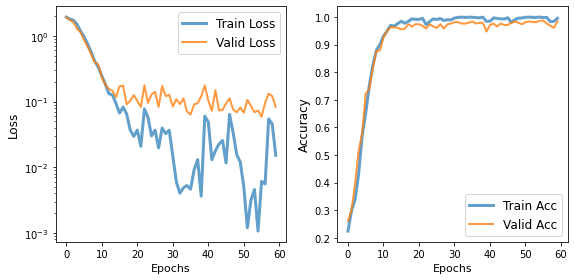

Classification Report:

              precision    recall  f1-score   support

       anger       0.98      0.97      0.97       119
    contempt       0.96      0.97      0.96       119
     disgust       0.97      1.00      0.98       118
        fear       0.98      0.99      0.99       119
   happiness       0.97      0.99      0.98       119
     neutral       0.91      0.88      0.90       119
     sadness       0.99      0.98      0.99       118
    surprise       1.00      0.98      0.99       118

    accuracy                           0.97       949
   macro avg       0.97      0.97      0.97       949
weighted avg       0.97      0.97      0.97       949



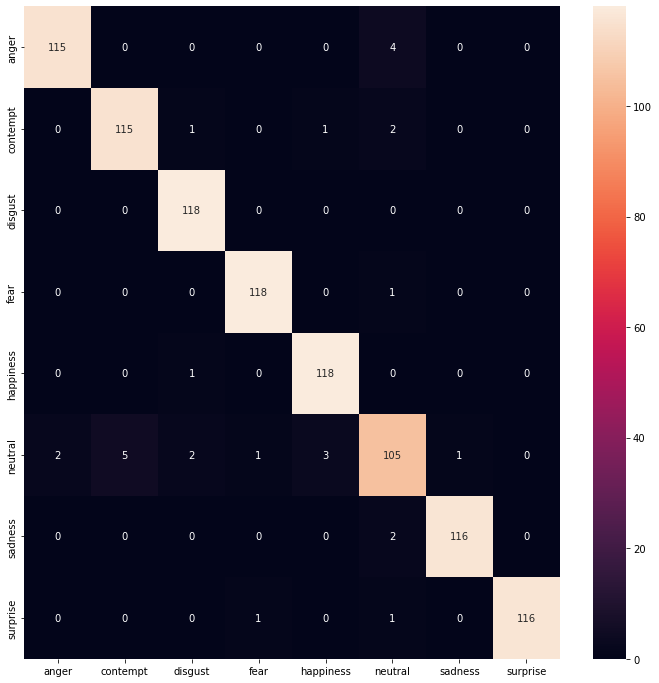

In [4]:
ck()

Epoch 1/60
1416/1416 [==============================] - 10s 6ms/step - loss: 1.6306 - accuracy: 0.3605 - auc_1: 0.7241 - val_loss: 1.4777 - val_accuracy: 0.4295 - val_auc_1: 0.7852
Epoch 2/60
1416/1416 [==============================] - 9s 6ms/step - loss: 1.3626 - accuracy: 0.4789 - auc_1: 0.8135 - val_loss: 1.3303 - val_accuracy: 0.4855 - val_auc_1: 0.8287
Epoch 3/60
1416/1416 [==============================] - 8s 6ms/step - loss: 1.2316 - accuracy: 0.5302 - auc_1: 0.8478 - val_loss: 1.2584 - val_accuracy: 0.5167 - val_auc_1: 0.8434
Epoch 4/60
1416/1416 [==============================] - 8s 6ms/step - loss: 1.1439 - accuracy: 0.5651 - auc_1: 0.8681 - val_loss: 1.2486 - val_accuracy: 0.5252 - val_auc_1: 0.8491
Epoch 5/60
1416/1416 [==============================] - 9s 6ms/step - loss: 1.0746 - accuracy: 0.5923 - auc_1: 0.8826 - val_loss: 1.1822 - val_accuracy: 0.5487 - val_auc_1: 0.8644
Epoch 6/60
1416/1416 [==============================] - 9s 6ms/step - loss: 1.0143 - accuracy: 0.61

1416/1416 [==============================] - 8s 6ms/step - loss: 0.2829 - accuracy: 0.8955 - auc_1: 0.9899 - val_loss: 2.3611 - val_accuracy: 0.6083 - val_auc_1: 0.8481
Epoch 47/60
1416/1416 [==============================] - 8s 5ms/step - loss: 0.2918 - accuracy: 0.8939 - auc_1: 0.9894 - val_loss: 2.4544 - val_accuracy: 0.6019 - val_auc_1: 0.8490
Epoch 48/60
1416/1416 [==============================] - 8s 6ms/step - loss: 0.2840 - accuracy: 0.8959 - auc_1: 0.9897 - val_loss: 2.5005 - val_accuracy: 0.6023 - val_auc_1: 0.8472
Epoch 49/60
1416/1416 [==============================] - 8s 5ms/step - loss: 0.2652 - accuracy: 0.9035 - auc_1: 0.9908 - val_loss: 2.4464 - val_accuracy: 0.6069 - val_auc_1: 0.8489
Epoch 50/60
1416/1416 [==============================] - 8s 6ms/step - loss: 0.2757 - accuracy: 0.8983 - auc_1: 0.9903 - val_loss: 2.4657 - val_accuracy: 0.5987 - val_auc_1: 0.8444
Epoch 51/60
1416/1416 [==============================] - 8s 6ms/step - loss: 0.2584 - accuracy: 0.9058 - au

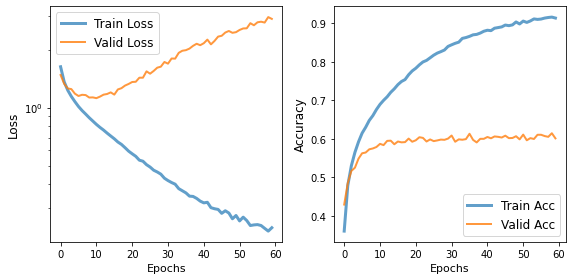

Classification Report:

              precision    recall  f1-score   support

       anger       0.45      0.56      0.50      1798
     disgust       0.92      0.96      0.94      1798
        fear       0.46      0.45      0.45      1798
   happiness       0.75      0.68      0.71      1798
     sadness       0.47      0.36      0.41      1798
    surprise       0.76      0.80      0.78      1798
     neutral       0.51      0.51      0.51      1797

    accuracy                           0.62     12585
   macro avg       0.62      0.62      0.61     12585
weighted avg       0.62      0.62      0.61     12585



NameError: name 'dir_list' is not defined

<Figure size 864x864 with 0 Axes>

In [5]:
fer()